In [ ]:
pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bdburak/AmazonReviewSentimentAnalysis/bdburak-patch-1/techNew.tsv', delimiter='\t', header=None,encoding='latin-1')

In [ ]:
batch1 = df[:2000]

In [ ]:
batch1[1].value_counts()

1    838
0    838
Name: 1, dtype: int64

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized = batch1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
print(tokenized)

0       [101, 1045, 2363, 2026, 9803, 17273, 14905, 17...
1       [101, 2023, 4003, 2003, 2107, 1037, 10520, 101...
2       [101, 2025, 2004, 3733, 2000, 2224, 2004, 1037...
3       [101, 2004, 1996, 2060, 12027, 2179, 2041, 101...
4       [101, 2023, 2003, 3819, 2005, 2026, 26322, 199...
                              ...                        
1671    [101, 2023, 2003, 1037, 3835, 2559, 2829, 1292...
1672    [101, 2200, 14044, 1998, 3733, 2005, 3087, 200...
1673    [101, 2023, 2003, 1037, 2204, 3715, 2099, 1011...
1674    [101, 2256, 2034, 3325, 2007, 1037, 6636, 6839...
1675    [101, 3532, 3579, 1010, 14819, 2854, 1010, 964...
Name: 0, Length: 1676, dtype: object


In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(1676, 66)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1676, 66)

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
labels = batch1[1]

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Test size helps with modularity of this code.

In [ ]:
testSize = len(test_labels)

# Ölçümler

In [ ]:
predict = lr_clf.predict(test_features)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(test_labels, predict)
print(cm)

[[188  21]
 [ 33 177]]


In [ ]:
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels)
sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
specifity = cm[1][1] / (cm[1][1] + cm[0][1])
#Precision= True_Positive/ (True_Positive+ False_Positive)
print("accuracy: " + str(accuracy))
print("sensitivity: " + str(sensitivity))
print("specifity: " + str(specifity))

accuracy: 0.8711217183770883
sensitivity: 0.8506787330316742
specifity: 0.8939393939393939


# Duzeltmeme

In [ ]:
for key,value in test_labels[4-1:4].items():
  print(value)

0


In [ ]:
fp, fn, tp, tn = (0,0,0,0)
value = 0

#this for loop will run for all the test samples and produce
#the confusion matrix for bert
for i in range(1,testSize):
  
  #I had to use a for loop that runs ones just because pandas doesn't let me 
  #get the value of a pandas series item
  for key,val in test_labels[i-1:i].items():
    value = val
  
  #placing the right prediction detection on top improves 
  #the performance of the algorithm
  #if the prediction was right
  if(lr_clf.score(test_features[i-1:i], test_labels[i-1:i]) == 1.0):
    if(val == 1):
      tp+=1

    elif(val == 0):
      tn+=1

  #if the prediction was wrong
  if(lr_clf.score(test_features[i-1:i], test_labels[i-1:i]) <1):
    if(val == 1):
      fp+=1

    elif(val == 0):
      fn+=1
  

lr_clf.score(test_features, test_labels)
print(tp+tn)

365


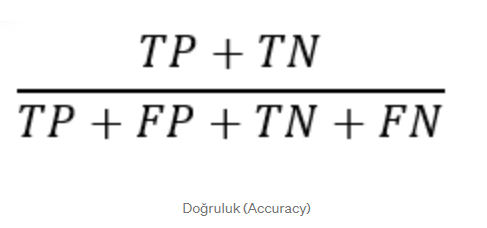

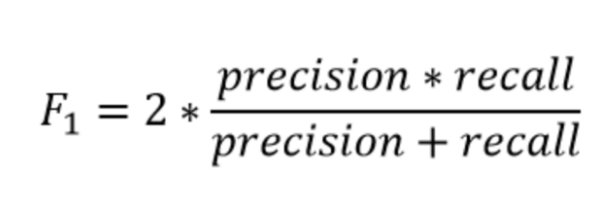

In [ ]:
lr_clf.score(test_features, test_labels)

0.8711217183770883

In [ ]:
def accuracy(tp,tn,fp,fn):
  return((tp+tn)/(tp+tn+fp+fn))
def precision(tp,fp):
  return (tp/(tp+fp))
def recall(tp,fn):
  return (tp/(tp+fn))
def f1():
  prec = precision(tp,fp)
  rec = recall(tp,fn)
  return(2*((prec*rec)/(prec+rec)))

print("accuracy: "+ str(accuracy(tp,tn,fp,fn)))
print("precision: "+ str(precision(tp,fp)))
print("recall: " + str(recall(tp,fn)))
print("f1: " + str(f1()))  

accuracy: 0.8732057416267942
precision: 0.8428571428571429
recall: 0.8984771573604061
f1: 0.8697788697788698


# Dummy classıfier ile alınan sonuçlar

Basit bir dummy classifier ile karşilaştırınca aradaki fark ortaya çıkmakta.

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.508 (+/- 0.04)


# Transformers kutuphanesinin sentiment analysis pipeline ı ile denedim

In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')



In [ ]:
for i in range(10):
  print(str(classifier(batch1[0][i])[0]['label']) + "|| " + str(batch1[1][i]) + "\n")

POSITIVE|| 1

NEGATIVE|| 0

POSITIVE|| 1

NEGATIVE|| 0

POSITIVE|| 1

POSITIVE|| 0

POSITIVE|| 1

NEGATIVE|| 0

POSITIVE|| 1

POSITIVE|| 0



In [ ]:
pred = []
for i in range(len(batch1[1])):
  if(classifier(batch1[0][i])[0]['label'] == "POSITIVE"):
     pred.append(1)
  if(classifier(batch1[0][i])[0]['label'] == "NEGATIVE"):
     pred.append(0)

In [ ]:
labelsCM = []
for i in range(len(batch1[1])):
  labelsCM.append(int(batch1[1][i]))

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(labelsCM, pred)
print(cm)

[[764  74]
 [134 704]]


In [ ]:
accuracy = (cm[0][0] + cm[1][1]) / len(labelsCM)
precision = cm[0][0] / (cm[0][0] + cm[0][1])
#Recall= True_Positive/ (True_Positive+ False_Negative)
recall = cm[0][0]/(cm[0][0] + cm[1][0])
specifity = cm[1][1] / (cm[1][1] + cm[0][1])
#Precision= True_Positive/ (True_Positive+ False_Positive)
f1 = 2*((precision*recall)/(precision+recall))
print("accuracy: " + str(accuracy))
print("sensitivity: " + str(precision))
print("specifity: " + str(specifity))
print("recall: " + str(recall))
print("f1: " + str(f1))


accuracy: 0.8758949880668258
sensitivity: 0.9116945107398569
specifity: 0.9048843187660668
recall: 0.8507795100222717
f1: 0.8801843317972351
